In [1]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
geo='DE'  
#['AD', 'AL', 'AM', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'GE', 'HR', 'HU', 'IE'x, 'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'ME', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UK']
age_ranges=[ 'Y_LT10', 'Y10-19', 'Y20-29', 'Y30-39', 'Y40-49', 'Y50-59', 'Y60-69', 'Y70-79', 'Y80-89', 'Y_GE90', 'TOTAL']
sex='T'

base_year=2020
current_year=2023
years=range(base_year-8,current_year+1)

deathsfile='demo_r_mwk_10.tsv.gz'#Deaths by week, sex and 10-year age groups
popfile='demo_pjan.tsv.gz'#Population on 1 January by age and sex
eurostat_base_url='https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/'
#source: 
#https://ec.europa.eu/eurostat/web/population-demography/demography-population-stock-balance/database

DEBUG=True


In [3]:
import os
import csv
import datetime
import sys
import gzip
import certifi
import urllib3
import io
from matplotlib import pyplot as plt
try:
  from countrycodes import cc2name,name2cc
except:
  cc2name=name2cc=lambda cc:cc

http=urllib3.PoolManager( cert_reqs='CERT_REQUIRED', ca_certs=certifi.where()) 

def open_eurostat_file(filename,localpath=os.getcwd()+'/Data/',remotepath='https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/'):
  if not os.path.exists(localpath+filename):
    if globals().get('DEBUG'): print(f'Downloading "{remotepath+filename}" from Eurostat.')
    with http.request('GET',remotepath+filename,preload_content=False) as r:
      if globals().get('DEBUG'): print(f'Saving "{localpath+filename}" locally.')
      with open(localpath+filename,'wb') as f:
        f.write(r.read())
  if globals().get('DEBUG'): print(f'Loading local "{localpath+filename}".')
  return gzip.open(localpath+filename,'rt',encoding='utf8')

def extract_eurostat_data(file='demo_r_mwk_10.tsv.gz', filter={'geo':'DE','sex':'T'}, fields=('age','year','week','value')):
  with open_eurostat_file(file) as f:
    Table=csv.DictReader(f,delimiter='\t')
    rowparamkeys=(Table.fieldnames[0].split('\\')[0]).split(',')
    rowparamkeyindex={key:i for i,key in enumerate(rowparamkeys)}
    filterset=set((rowparamkeyindex[key],value) for key,value in filter.items())
    for rec in Table:
      rowparams=rec[Table.fieldnames[0]].split(',')
      if filterset.issubset(set(enumerate(rowparams))):#filter for rows that match the filter
        fields_=dict(zip(rowparamkeys,rowparams))
        for key,value in rec.items(): #iterate through all columns of the table
         if key!=Table.fieldnames[0]: #skip the first column with the row parameters
            val=value.split()[0]
            if val.isnumeric():
              fields_['value']=int(val)
            else:
              continue #skip if there is no value in the row/column
            if 'W' in key:
              year,week=key.split('W') #split the column heading in year and week of year
            else:
              year=key
              week=0
            fields_['year']=int(year)
            fields_['week']=int(week)
            yield(fields_[key] for key in fields)

def extract_eurostat_Fieldvalues(file='demo_r_mw.tsv.gz',):
  with open_eurostat_file(file) as f:
    Table=csv.DictReader(f,delimiter='\t')
    fieldnames=Table.fieldnames[0].split('\\')[0].split(',')
    fieldindex={f:i for i,f in enumerate(fieldnames)}
    fieldvalue={fieldname:set() for fieldname in fieldnames}
    for r in Table:
      fields=r[Table.fieldnames[0]].split(',')
      for fieldname,field in zip(fieldnames,fields):
        fieldvalue[fieldname].add(field)
  return fieldvalue


In [4]:
deaths_w={}
max_week={}
for age,year,week,val in extract_eurostat_data(deathsfile,filter={'geo':geo,'sex':sex}, fields=('age','year','week','value')):
  if not age in deaths_w:
    deaths_w[age]=dict([])
  if not year in deaths_w[age]:
    deaths_w[age][year]=[0]*54
    max_week[year]=0
  if week<54:
   deaths_w[age][year][week]=val
   max_week[year]=max(max_week[year],week)
  else:
    if week!=99:
      print(week)
      
deaths_a={age:{year:sum(weeks) for year,weeks in years.items()} for age,years in deaths_w.items()}#sum over weeks


Loading local "/private/var/mobile/Containers/Data/Application/77881549-3FA6-4E4B-803F-D53B172FC865/Documents/Eurostat/Data/demo_r_mwk_10.tsv.gz".


In [5]:
#sum up the population into age-groups that match the age groups in the deaths database:
pop={}
for age,year,val in extract_eurostat_data(popfile,filter={'geo':geo,'sex':sex}, fields=('age','year','value')):
  if age=='Y_LT1':
    age='Y0'
  if age=='Y_OPEN':
    age='Y_GE90'
  if age[:1]=='Y':
    if (age[1:]).isnumeric():
      age=int(age[1:])
      if age<10:
        age='Y_LT10'
      elif age>=90:
        age='Y_GE90'
      else:
        age=f'Y{age//10*10:2d}-{age//10*10+9:2d}'
  if not age in pop:
    pop[age]=dict([])
  if not year in pop[age]:
    pop[age][year]=0
  pop[age][year]+=val


Loading local "/private/var/mobile/Containers/Data/Application/77881549-3FA6-4E4B-803F-D53B172FC865/Documents/Eurostat/Data/demo_pjan.tsv.gz".


In [6]:
#calculate the mortalities for each age group:
mort={}
for age in age_ranges:
  mort[age]={}
  for year in years:
    try:
      x=deaths_a[age][year]/pop[age][year-1]
      mort[age][year]=x/(max_week[year]*7)*365.2422
    except KeyError:
      continue

#calculate the age-adjusted mortality for the base_year
mort[f'base{base_year}']={}
for year in years:
  try:
    s=0
    for age in age_ranges[:-1]:
      s+=deaths_a[age][year]/pop[age][year-1]*pop[age][base_year-1]
    x=s/pop["TOTAL"][base_year-1]
    mort[f'base{base_year}'][year]=x/(max_week[year]*7)*365.2422
  except KeyError:
    continue
    
mortyears=list(mort[f'base{base_year}'].keys())
print()
print(f'Mortalities [%/year], {cc2name(geo)}:')
print()
print(f'{"age|years:":10s}{"".join([f" {y:5d}" for y in mortyears])}')      
for age,row in mort.items():
  print(f'{age:10s}',end=' ')   
  print(''.join([f'{mort[age].get(y,0)*100.0:5.2f} ' for y in mortyears]))



Mortalities [%/year], Germany:

age|years:  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
Y_LT10      0.04  0.04  0.04  0.05  0.05  0.05  0.04  0.04  0.04  0.04  0.04  0.04 
Y10-19      0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.01  0.02  0.02  0.02 
Y20-29      0.04  0.04  0.03  0.04  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03 
Y30-39      0.06  0.06  0.06  0.07  0.07  0.06  0.06  0.06  0.06  0.06  0.07  0.06 
Y40-49      0.17  0.16  0.16  0.16  0.16  0.15  0.15  0.14  0.15  0.16  0.16  0.16 
Y50-59      0.49  0.49  0.47  0.48  0.46  0.45  0.45  0.43  0.42  0.44  0.43  0.43 
Y60-69      1.10  1.14  1.09  1.16  1.18  1.16  1.17  1.14  1.15  1.21  1.20  1.22 
Y70-79      2.73  2.73  2.62  2.66  2.54  2.61  2.66  2.59  2.62  2.71  2.77  2.89 
Y80-89      8.61  8.73  8.32  8.96  8.47  8.46  8.37  8.00  8.25  8.18  8.30  8.47 
Y_GE90     26.89 25.85 23.86 25.60 24.07 24.86 24.85 24.04 25.22 24.78 26.09 26.86 
TOTAL       1.08  1.11  1.08  1.15  1.12  1.

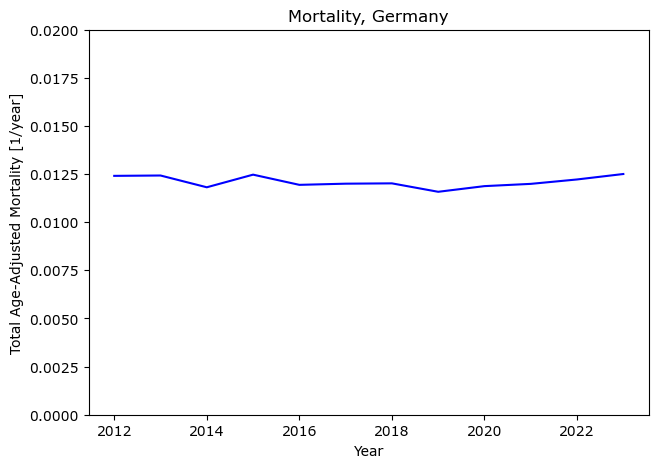

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi']=100
plt.ylabel('Total Age-Adjusted Mortality [1/year]')
plt.xlabel('Year')
plt.title(f'Mortality, {cc2name(geo)}')
plt.plot(list(mort[f'base{base_year}'].keys()),list(mort[f'base{base_year}'].values())[:],'b')
plt.subplots_adjust(left=0.15,right=0.95)
_=plt.ylim(bottom=0.0,top=0.02)
#plt.savefig(f'am_{geo}.pdf')


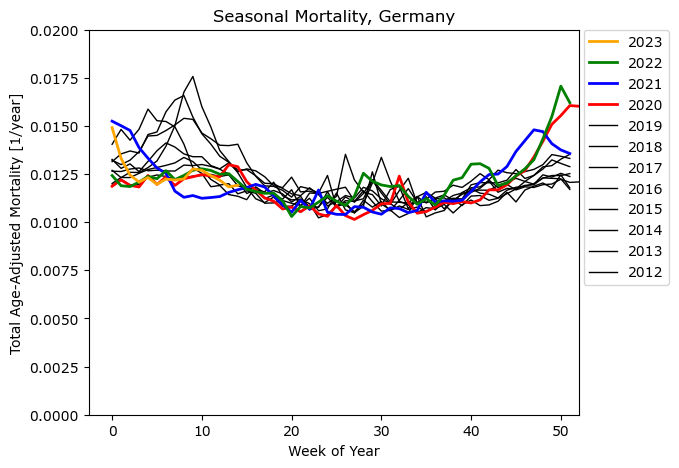

In [8]:
plt.close()
for year,weeks in deaths_w['TOTAL'].items() :
    if (not (year in mortyears)) or (mort['TOTAL'][year]==0):
        continue
    last_week=len(weeks)
    while weeks[last_week-1]==0 and last_week>0:
      last_week-=1
    age_adj=mort[f'base{base_year}'][year]/mort['TOTAL'][year]
    plt.plot([age_adj*y/pop["TOTAL"][year-1]*365.25/7 for y in weeks[1:last_week]], 
     **(  
          dict(c='r',lw=2,zorder=1,) if year==2020
     else dict(c='b',lw=2,zorder=2,) if year==2021
     else dict(c='g',lw=2,zorder=3,) if year==2022     
     else dict(c='orange',lw=2,zorder=4,) if year==2023 
     else dict(c='k',lw=1,zorder=0,) 
       ),
        label=f'{year}')
plt.ylabel('Total Age-Adjusted Mortality [1/year]')
plt.xlabel('Week of Year')
plt.title(f'Seasonal Mortality, {cc2name(geo)}')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.0)
plt.ylim(bottom=0,top=0.02)
plt.xlim(right=52)
plt.subplots_adjust(left=0.14,right=0.84)# make space for legend to the right
#plt.savefig(f'sm_{geo}.pdf')


In [9]:
if DEBUG:
  #check if calculated weekly and annual mortalities add up:
  year=mortyears[-2]
  age_adj=mort[f'base{base_year}'][year]/mort['TOTAL'][year]
  print(mort[f'base{base_year}'][year])
  print(sum([age_adj*deaths/pop["TOTAL"][year-1]*365.2422/7 
             for deaths in deaths_w['TOTAL'][year][1:]])/max_week[year])


0.01222136184212788
0.01222136184212788
